## Phantom vs Vandal Dataframe

The majority of the work is done in player_model.ipynb

This was just a separate notebook focused on the Phantom Vandal debate, which is not nearly as important as the wins_above_expected metrics elsewhere. I would recommend reading that instead. 

See README this is not the final version. See util for function defintions and usage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util import * 
import xgboost as xgb

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
MD = MatchesData()
features = [
            'px','py',
            'roundTime', 
            'isPlanted', 'spikeBPS',
            'pgun', 'parmor', 
            'atkAlive','defAlive',
            'atkNumGuns','defNumGuns','roundHalf', 
            'atkWonLast','defWonLast',
            ]

In [3]:
allmaps_PV = []
allmaps_PV_df = []

maps = ['Ascent', 'Bind', 'Breeze', 'Haven', 'Icebox', 'Split']

for mapname in maps:
    MapData = DuelsData('DATA_XY/VCT3_NA_All.csv', mapname=mapname)

    one_map_params = {'colsample_bytree': 0.7581049567418119, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 55, 'subsample': 0.4196367095952316}
    
    one_map_features = [
            'px','py',
            'roundTime', 
            'isPlanted', 'spikeBPS',
            'pgun', 'parmor', 
            # 'atkAlive','defAlive',
            # 'atkNumGuns','defNumGuns','roundHalf', 
            # 'atkWonLast','defWonLast',
            # 'MapInt'
            ]

    map_preds = PredATKDEF(
    MapData, 
    MD.train_valid_matches, 
    MD.test_matches, 
    one_map_features, 
    xgb.XGBClassifier(use_label_encoder = False, verbosity = 0, random_state=42,
             **one_map_params,),
    MD.df_ids 
    )

    y_true, y_pred, dfexp = map_preds.fitpred_ATKDEF()

    for isatk in [0,1]:

        dfg = dfexp[dfexp.isATK == isatk]

        dfcase1 = dfg[dfg['pgun'] == 2900]
        dfcase2 = dfg[dfg['pgun'] == 2901]

        dfcase1_alt = dfcase1.copy()
        dfcase1_alt['pgun'] = 2901
        dfcase2_alt = dfcase2.copy()
        dfcase2_alt['pgun'] = 2900

        if isatk == 0:
            dfcase1_alt['PROBA'] = map_preds.modelDEF.predict_proba(dfcase1_alt[map_preds.features])
            dfcase2_alt['PROBA'] = map_preds.modelDEF.predict_proba(dfcase2_alt[map_preds.features])

        elif isatk == 1:
            dfcase1_alt['PROBA'] = map_preds.modelATK.predict_proba(dfcase1_alt[map_preds.features])
            dfcase2_alt['PROBA'] = map_preds.modelATK.predict_proba(dfcase2_alt[map_preds.features])

        vandal_avg = np.mean(pd.concat([dfcase2['PROBA'], dfcase1_alt['PROBA']]))
        phantom_avg = np.mean(pd.concat([dfcase1['PROBA'], dfcase2_alt['PROBA']]))


        phantom_edge1 = dfcase1['PROBA'] - dfcase1_alt['PROBA']
        phantom_edge2 = dfcase2_alt['PROBA'] - dfcase2['PROBA']

        phantom_edge = pd.concat([phantom_edge1, phantom_edge2])

        df_phantom_edge = pd.DataFrame({'mapname': mapname, 'isATK':isatk, 'phantom_advantage': phantom_edge })
        allmaps_PV_df.append(df_phantom_edge)


        side = 'ATK' if isatk == 1 else 'DEF'
        allmaps_PV.append({
            'mapname': mapname,
            'side': side,
            # 'Phantom_advantage': phantom_edge.mean(),
            'Vandal_avg': vandal_avg,
            'Phantom_avg': phantom_avg

        })

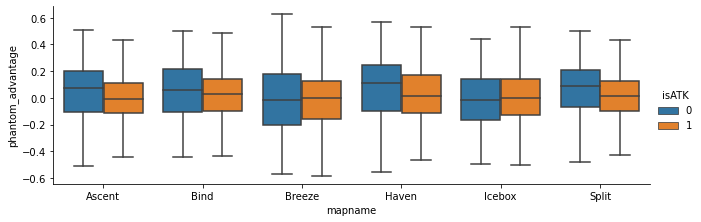

In [4]:
dfplot = pd.concat(allmaps_PV_df)

sns.catplot(x = "mapname", y = "phantom_advantage", 
            hue = "isATK", kind = "box", data = dfplot, 
            showfliers = False,
            height = 3,
            aspect = 3/1)

In [5]:
dfavg = pd.DataFrame(allmaps_PV).round(3)
dfavg['Phantom Advantage'] = dfavg.Phantom_avg - dfavg.Vandal_avg
dfavg.sort_values('Phantom Advantage').set_index('mapname')

,side,Vandal_avg,Phantom_avg,Phantom Advantage
mapname,,,,
Breeze,ATK,0.508,0.490,-0.018
Icebox,DEF,0.509,0.493,-0.016
Breeze,DEF,0.507,0.496,-0.011
Ascent,ATK,0.499,0.498,-0.001
Icebox,ATK,0.500,0.507,0.007
Split,ATK,0.489,0.505,0.016
Haven,ATK,0.488,0.506,0.018
Bind,ATK,0.493,0.518,0.025
Ascent,DEF,0.476,0.528,0.052


In [6]:
preds = pd.read_csv('DATA_XY/ORT_OUT/Grid_DEF_TEST_01.csv')

In [7]:
griddf0 = DuelsData('DATA_XY/VCT3_NA_All.csv').generate_data_grid(N = 7)

remaining_features = {
    'roundTime': 40,
    'isPlanted': 0,
    'spikeBPS': -1,
    'pgun': 2900,
    'parmor': 2,
    'atkAlive': 5,
    'defAlive': 5,
    'atkNumGuns': 5,
    'defNumGuns': 5,
    'roundHalf': 4,
    'atkWonLast': 0,
    'defWonLast': 1,
    'MapInt': 1
}
remaining_features = {key: remaining_features[key] for key in features[2:]}

for feat in remaining_features.keys():
    griddf0[feat] = remaining_features[feat]

griddiff = griddf0.copy()
griddiff['PROBA_0'] = preds['pred0']
griddiff['PROBA_1'] = preds['pred1']
griddiff['PROBA'] =  preds['pred0'] - preds['pred1']
griddiff['PROBA'].mean()

-0.0020866097320477186

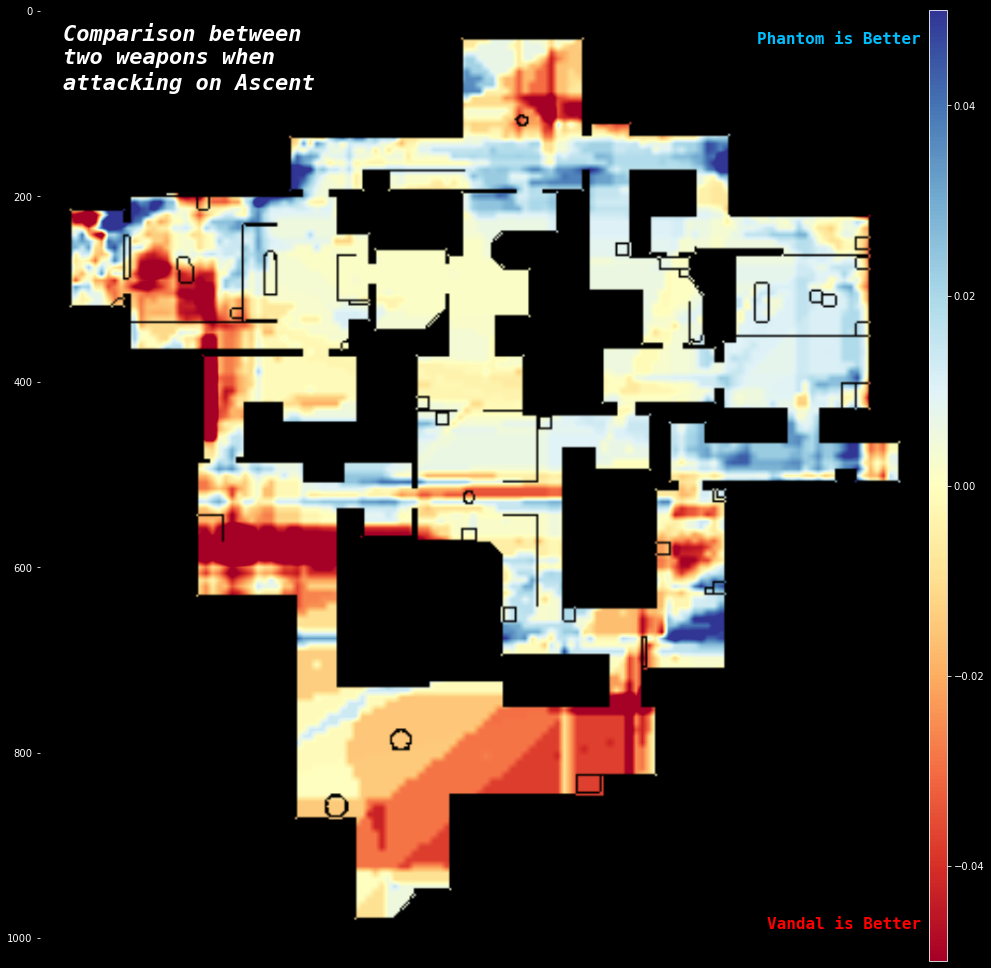

In [8]:
plt.style.use('dark_background')

N = 7
dfpred = griddiff.copy()
midpoint = 0
c_range = 0.05

MAP = 'Ascent'
map_image = io.imread('IMAGES/MAP_PNGS/{}_contour.png'.format(MAP))
SIZE_FIG =(14, 13.2)
shift_map = {'Haven':{'xshift': -50, 'yshift':-10, 'xmax': 915, 'ymin': -1015}, 
        'Icebox':{'xshift': -36.5, 'yshift':27, 'xmax': 915, 'ymin': -1015},
        'Ascent':{'xshift': -53.5, 'yshift':-12, 'xmax': 955, 'ymin': -1025},
        'Bind':{'xshift': -112, 'yshift':15, 'xmax': 865, 'ymin': -1038},
        'Split':{'xshift': -1.5, 'yshift':-23, 'xmax': 1010, 'ymin': -956},
        'Breeze':{'xshift': 2, 'yshift':-12, 'xmax': 992, 'ymin': -975}
        }

xmin, xmax = 0, shift_map[MAP]['xmax']
ymax, ymin = 0, shift_map[MAP]['ymin']
holes = map_image[:,:,2]
base = resize(holes, [ymax-ymin, xmax-xmin])
XMAX = base.shape[1]
YMAX = base.shape[0]

xx, yy = np.meshgrid(np.linspace(0, XMAX, int(XMAX/N)),
                    np.linspace(0, YMAX, int(YMAX/N)))
gridpred = dfpred.values[:,-1]
gridz = gridpred.reshape(xx.shape)
fig = plt.figure(figsize=SIZE_FIG)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)

grid_show = resize(gridz, [ymax-ymin, xmax-xmin])
im = ax.imshow(grid_show, cmap = 'RdYlBu', 
            norm = colors.TwoSlopeNorm(vmin=midpoint-c_range, vcenter=midpoint, 
                                            vmax=midpoint+c_range), 
            alpha = 1) ## actual grid

ax.imshow(255*np.ones(grid_show.shape), alpha = 1 - base, cmap = 'gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
ax.set_xticks([])
# ax.set_yticks([])

title_font = {'horizontalalignment': 'right', 
            'verticalalignment': 'baseline', 
            'fontfamily':'monospace',
            'weight':'bold',
            }

ax.text(25, 85, "Comparison between \ntwo weapons when \nattacking on Ascent", fontsize = 22,
        fontfamily ='monospace', weight = 'bold', fontstyle = 'italic') 

ax.text(950, 35, "Phantom is Better", fontsize = 16, **title_font, c = 'deepskyblue') 
ax.text(950, 990, "Vandal is Better", fontsize = 16, **title_font, c = 'r') 
plt.colorbar(im, cax = cax)